In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt, ceil, log2
from decision_tree import DecisionTree, Utils

In [2]:
# from ucimlrepo import fetch_ucirepo 
  
# # fetch dataset 
# mushroom = fetch_ucirepo(id=73) 
  
# x = mushroom.data.features 
# y = mushroom.data.targets 

# y = y['poisonous']



mushroom = pd.read_csv("mushroom.csv")
mushroom.replace('?', np.nan, inplace=True)
x = mushroom.drop("poisonous", axis = 1)
y = mushroom["poisonous"]


x.info()
y.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

у признка stalk-root есть null-элементы, заполним их модой

In [3]:

Utils.fill_mode(x, "stalk-root")
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

# Визуализация

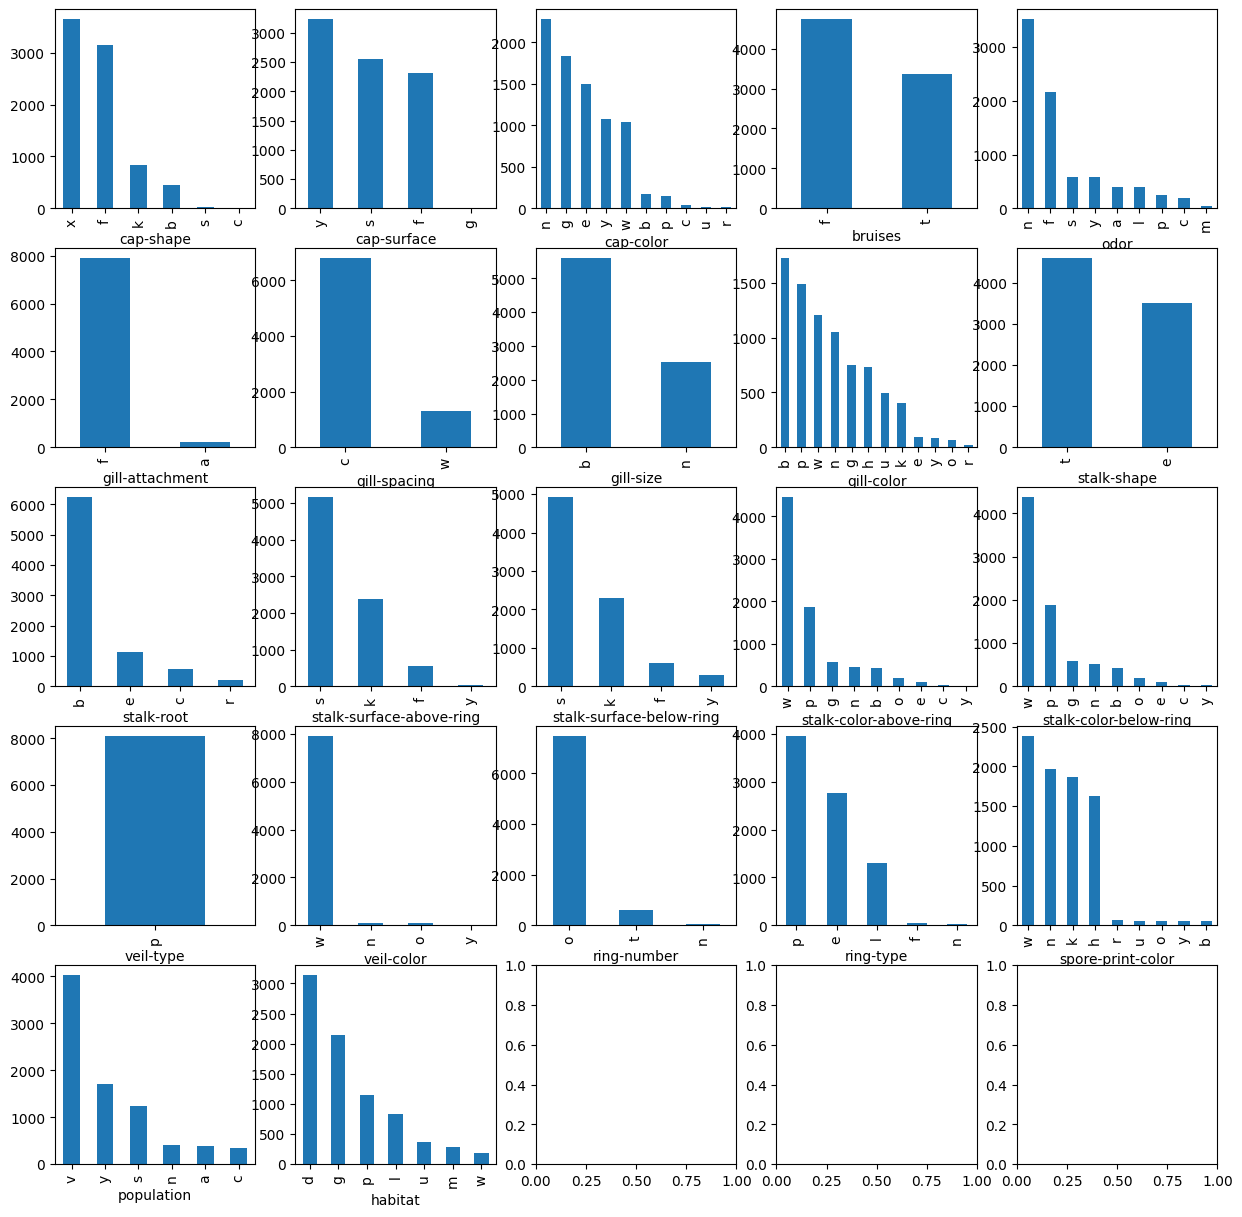

In [4]:
fig, axs = plt.subplots(ceil(sqrt(len(x.columns))), ceil(sqrt(len(x.columns))))
for ax, col in zip(axs.flatten(), x.columns):
    x[col].value_counts().plot(kind="bar", ax=ax)
fig.set_figheight(15)
fig.set_figwidth(15)

<Axes: xlabel='poisonous'>

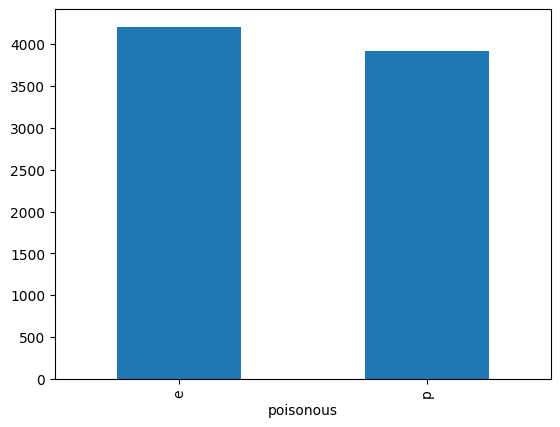

In [5]:
y.value_counts().plot(kind="bar")

# Разделение на тестовый и обучающий наборы

In [4]:
samples_amount = 0.3
random_state = 526973

(test_x, test_y, train_x, train_y) = Utils.split(x, y, samples_amount, random_state)

# Тренировка

In [24]:
cols = x.columns
cols = np.random.choice(cols, ceil(sqrt(len(cols))), replace=False)

print("Признаки:", *cols)

tree = DecisionTree(cols)
tree.fit(train_x, train_y)
tree.print_tree()

Признаки: stalk-color-below-ring veil-color stalk-color-above-ring veil-type cap-shape
stalk-color-above-ring == w:
		-> e (0.6185928048392232)
stalk-color-above-ring == g:
		-> e (1)
stalk-color-above-ring == p:
		stalk-color-below-ring == w:
				-> p (0.6893424036281179)
		stalk-color-below-ring == p:
				-> p (0.7602996254681648)
		stalk-color-below-ring == g:
				-> e (1)
		stalk-color-below-ring == b:
				-> p (1)
		stalk-color-below-ring == n:
				-> p (1)
stalk-color-above-ring == n:
		cap-shape == x:
				stalk-color-below-ring == b:
						-> p (1)
				stalk-color-below-ring == p:
						-> p (1)
				stalk-color-below-ring == n:
						-> p (0.9607843137254902)
		cap-shape == f:
				-> p (0.9727891156462585)
		cap-shape == b:
				-> e (1)
		cap-shape == k:
				-> e (1)
stalk-color-above-ring == b:
		-> p (1)
stalk-color-above-ring == e:
		-> e (1)
stalk-color-above-ring == o:
		-> e (1)
stalk-color-above-ring == c:
		-> p (1)
stalk-color-above-ring == y:
		-> p (1)


# Тестирование

In [27]:
pred_y = tree.pred(test_x)
conf = Utils.confusion_matrix(pred_y, test_y)
print(conf)
print('Accuracy:', Utils.accuracy(conf))
print('Precision', Utils.precision(conf))
print('Recall:', Utils.recall(conf))

[[ 667.  121.]
 [ 514. 1135.]]
Accuracy: 0.7394337299958966
Precision 0.6882959369314736
Recall: 0.9036624203821656


# AUC

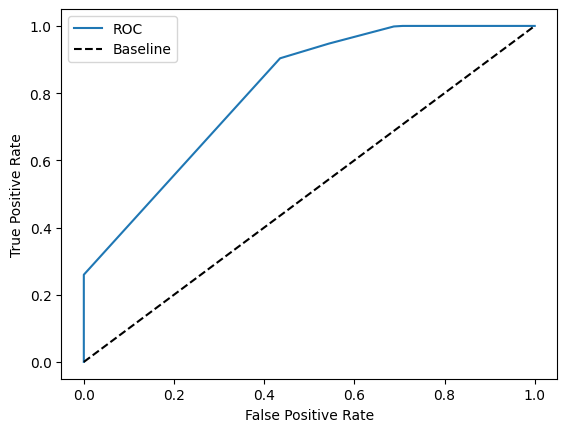

In [28]:
pred_prob = tree.pred_prob(test_x)
probs = []

for i in range(len(pred_prob)):
    pred, prob = pred_prob[i]
    if pred == 'e':
        probs.append(prob)
    else:
        probs.append(1-prob)

tpr = []
fpr = []

for th in np.arange(1, 0, -0.01):
    conf = Utils.confusion_matrix_prob(probs, test_y, th)
    tpr.append(Utils.recall(conf))
    fpr.append(Utils.fallout(conf))

plt.plot([0] + fpr + [1], [0] + tpr + [1], label='ROC')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'k--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

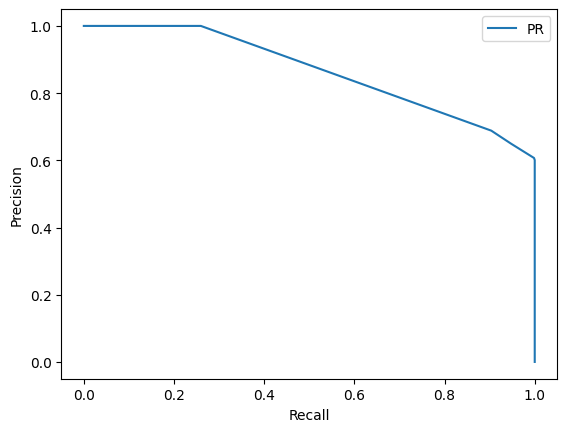

In [29]:
p = []
r = []

for th in np.arange(0, 1, 0.01):
    conf = Utils.confusion_matrix_prob(probs, test_y, th)
    p.append(Utils.precision(conf))
    r.append(Utils.recall(conf))

plt.plot([1] + r + [0], [0] + p + [1], label='PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()